In [20]:
import torch
import matplotlib.pyplot as plt

from pedalboard.pedalboard import load_plugin

from src.dataset.paired_audio_dataset import PairedAudioDataset
from src.wrappers.dafx_wrapper import DAFXWrapper
from src.wrappers.null_dafx_wrapper import NullDAFXWrapper

from src.models.style_transfer_vae import StyleTransferVAE

In [21]:
DAFX_FILE = "/home/kieran/Level5ProjectAudioVAE/src/dafx/mda.vst3"
DAFX_NAME = "mda Overdrive"
SAMPLE_RATE = 24_000
AUDIO_DIR = "/home/kieran/Level5ProjectAudioVAE/src/audio"
DATASETS = ["vctk_24000"]
NUM_EXAMPLES = 10
CHECKPOINT = "/home/kieran/Level5ProjectAudioVAE/src/l5proj_style_vae/aoo9px7h/checkpoints/epoch=590-step=369375.ckpt"
CHECKPOINT_ID = CHECKPOINT.split("/")[-3]

In [22]:
def show_spectrogram(audio):
    if len(audio.shape) == 1:
        audio = audio.unsqueeze(0)
        audio = audio.unsqueeze(0)

    spec = StyleTransferVAE.audio_to_spectrogram(signal=audio, return_phase=False)
    plt.imshow(spec.detach().squeeze(), aspect='auto')
    plt.show()

In [23]:
def spectrogram_to_audio(X: torch.Tensor,
                         n_fft: int = 4096,
                         hop_length: int = 2048,
                         window_size: int = 4096):

    X_un_db_norm = X.permute(0, 1, 3, 2).squeeze()
    X_un_db_norm = X_un_db_norm[0]
    X_un_db_norm *= 0.2745147
    X_un_db_norm += 0.3352797

    X_un_db_norm = torch.pow(X_un_db_norm, 3)
    X_un_db_norm -= 1e-8

    window = torch.nn.Parameter(torch.hann_window(window_size)).to(X.device)

    signal = torch.istft(
        X_un_db_norm,
        n_fft=n_fft,
        hop_length=hop_length,
        window=window,
        return_complex=True,
    )

    return signal

In [24]:
if DAFX_NAME.lower() == "clean":
    dafx = NullDAFXWrapper()
else:
    dafx = load_plugin(DAFX_FILE, plugin_name=DAFX_NAME)
    dafx = DAFXWrapper(dafx=dafx, sample_rate=SAMPLE_RATE)

In [25]:
dataset = PairedAudioDataset(
    dafx=dafx,
    audio_dir=AUDIO_DIR,
    subset="train",
    input_dirs=DATASETS,
    num_examples_per_epoch=NUM_EXAMPLES,
    augmentations={},
    length=131_072,
    effect_input=False,
    effect_output=True,
    dummy_setting=True
)

loader= torch.utils.data.DataLoader(
    dataset,
    num_workers=4,
    batch_size=1,
    timeout=6000,
)

100%|████████████████████████████████████████| 88/88 [00:00<00:00, 35002.25it/s]


Loaded 88 files for train = 66.89 hours.


In [26]:
model = StyleTransferVAE.load_from_checkpoint(CHECKPOINT)
model.eval()

StyleTransferVAE(
  (encoder_conv): Sequential(
    (0): Sequential(
      (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (mu): Linear(in_features=20640, out_features=4096, bias=True)
  (log_var): Linear(in_features=2064

In [27]:
batch = next(iter(loader))
x, y = batch

In [28]:
from IPython.display import Audio

In [29]:
x.shape

torch.Size([1, 1, 131072])

In [30]:
Audio(x.numpy().squeeze(), rate=SAMPLE_RATE)

In [31]:
from src.utils import audio_to_spectrogram

x_s = audio_to_spectrogram(signal=x)
y_s = audio_to_spectrogram(signal=y)

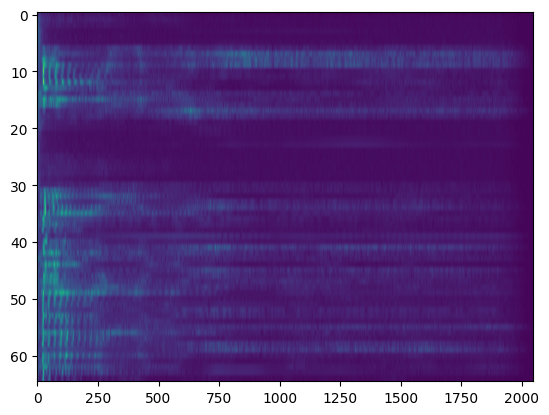

In [32]:
show_spectrogram(x)

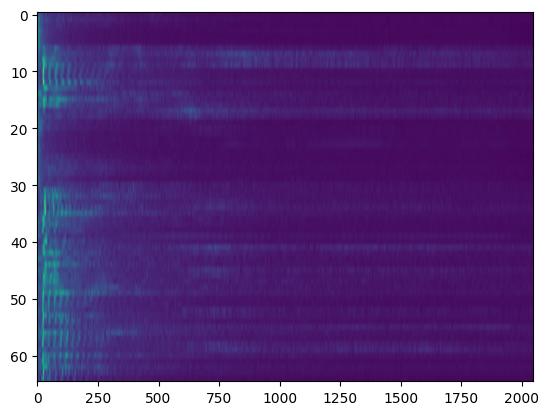

In [33]:
show_spectrogram(y)

In [34]:
X = torch.concat([x_s, y_s], dim=1)

In [35]:
X.shape

torch.Size([1, 2, 65, 2049])

In [36]:
X_hat, _, _, z = model(X)

In [37]:
X_hat.shape

torch.Size([1, 2, 65, 2049])

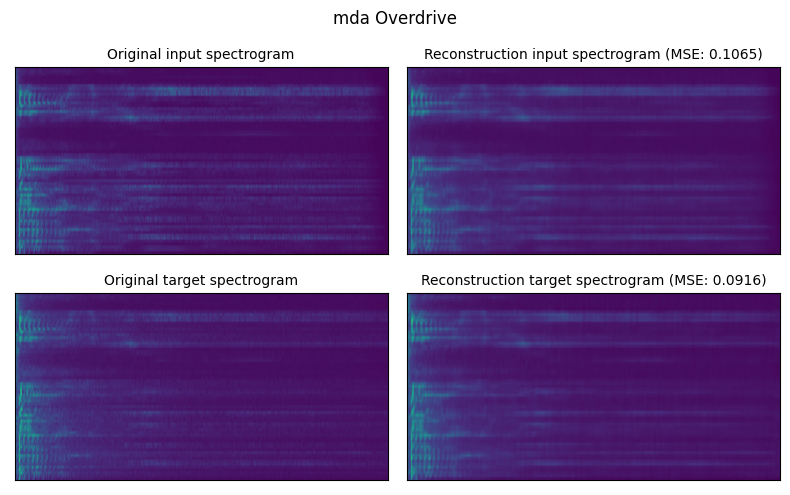

In [38]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(8,5))

labels = ['input spectrogram', 'target spectrogram']

# find minimum of minima & maximum of maxima
minmin = min([torch.min(X).item(), torch.min(X_hat).item()])
maxmax = max([torch.max(X).item(), torch.max(X_hat).item()])

# for each dimension
for i in range(2):
    mse = F.mse_loss(X[0,i,:,:], X_hat[0,i,:,:])

    ax1 = axes[i, 0].imshow(X[0,i,:,:].detach().squeeze().numpy(),
                            aspect='auto',
                            vmin=minmin,
                            vmax=maxmax
                            )

    ax2 = axes[i, 1].imshow(X_hat[0,i,:,:].detach().squeeze().numpy(),
                            aspect='auto',
                            vmin=minmin,
                            vmax=maxmax
                            )

    axes[i, 0].set_title(f"Original {labels[i]}", fontsize=10)
    axes[i, 1].set_title(f"Reconstruction {labels[i]} (MSE: {mse.item():.4f})", fontsize=10)

    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])

    axes[i, 1].set_xticks([])
    axes[i, 1].set_yticks([])


# plt.savefig("./figures/spectrogram_reconstruction_lo_kld.png")

# add space for colour bar
fig.subplots_adjust(right=0.85)
# cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
# fig.colorbar(ax2, cax=cbar_ax)
fig.suptitle(DAFX_NAME)

plt.tight_layout()
plt.savefig(f"./figures/reconstructions/{CHECKPOINT_ID}_{DAFX_NAME.split()[-1].lower()}_joint_reconstruction.svg")